<a href="https://colab.research.google.com/github/soumyajoykundu/Applied-Machine-Learning-2025/blob/main/Assignments/Project/Code%20files/SonicShield_EDA_%26_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **AML Project**

**Team AudioSentinels**
1. Chandranath Bhattacharya -- MDS202318
2. Salokya Deb -- MDS202341
3. Soumyajoy Kundu -- MDS202349

**$$\text{SonicShield :
AI-Powered Guardian Against DeepFake Speech}$$**


This notebook is the first part of our work where we have done some data analysis to understand the composition of the data and applied relevant data preprocessing steps. The following contents are covered here,
1. Exploratory Data Analysis
2. Data Preprocessing

*Note*: The apps are developed on the model fine-tuned on our data under study.

Link to the data : [Kaggle](https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition/data)

In [ ]:
!pip install librosa spleeter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.7 MB/s eta 0:0

### Importing Libraires

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import random

import librosa
import spleeter
import xgboost
import sklearn
import tensorflow as tf

print("All libraries imported successfully!")

All libraries imported successfully!


In [ ]:
print("GPU Available:", tf.test.is_gpu_available())
print("Colab Runtime:", "GPU" if tf.test.is_gpu_available() else "CPU")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: False
Colab Runtime: CPU


### Loading Data

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"soumyajoykundu","key":"76589696c2c34c4ecffdce1807d986ac"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d birdy654/deep-voice-deepfake-voice-recognition
!unzip deep-voice-deepfake-voice-recognition.zip -d deep-voice-dataset

Dataset URL: https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition
License(s): other
Archive:  deep-voice-deepfake-voice-recognition.zip
  inflating: deep-voice-dataset/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3  
  inflating: deep-voice-dataset/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3  
  inflating: deep-voice-dataset/KAGGLE/AUDIO/FAKE/Obama-to-Biden.wav  
  inflating: deep-voice-dataset/KAGGLE/AUDIO/FAKE/Obama-to-Trump.wav  
  inflating: deep-voice-dataset/KAGGLE/AUDIO/FAKE/biden-to-Obama.wav  
  inflating: deep-voice-dataset/KAGGLE/AUDIO/FAKE/biden-to-Trump.wav  
  inflating: deep-voice-dataset/KAGGLE/AUDIO/FAKE/biden-to-linus.wav  
  inflating: deep-voice-dataset/KAGGLE/AUDIO/FAKE/biden-to-margot.wav  
  inflating: deep-voice-dataset/KAGGLE/AUDIO/FAKE/biden-to-musk.wav  
  inflating: deep-voice-dataset/KAGGLE/AUDIO/FAKE/biden-to-ryan.wav  
  inflating: deep-voice-dataset/KAGGLE/AUDIO/FAKE/biden-to-taylor.wav  
  inflating: deep-voice-data

In [ ]:
!ls /content/deep-voice-dataset

DEMONSTRATION  KAGGLE


In [ ]:
base_dir = '/content/deep-voice-dataset/KAGGLE/AUDIO'
real_dir = os.path.join(base_dir, 'REAL')
fake_dir = os.path.join(base_dir, 'FAKE')

real_files = [f for f in os.listdir(real_dir) if f.endswith('.wav')] if os.path.exists(real_dir) else []
fake_files = [f for f in os.listdir(fake_dir) if f.endswith('.wav')] if os.path.exists(fake_dir) else []

print(f"Total .wav files: {len(real_files) + len(fake_files)}")
print(f"Real files: {len(real_files)}")
print(f"Fake files: {len(fake_files)}")
print(f"Sample real files: {real_files[:3]}")
print(f"Sample fake files: {fake_files[:3]}")

Total .wav files: 64
Real files: 8
Fake files: 56
Sample real files: ['margot-original.wav', 'linus-original.wav', 'ryan-original.wav']
Sample fake files: ['trump-to-taylor.wav', 'taylor-to-trump.wav', 'biden-to-margot.wav']


#### Audio files
* Anyone can run this kernel and the output will be the audio files which can be clicked to listen the audio
* Each file is of ~100 MB which was becoming difficult for this notebook's storage, so we have skipped this.

In [ ]:
import IPython.display as ipd

# Define paths to your audio files
obama_original_path = "/content/deep-voice-dataset/KAGGLE/AUDIO/REAL/obama-original.wav"
musk_original_path = "/content/deep-voice-dataset/KAGGLE/AUDIO/REAL/musk-original.wav"
obama_to_musk_fake_path = "/content/deep-voice-dataset/KAGGLE/AUDIO/FAKE/obama-to-musk.wav"

print('Real Audio Files:')
if os.path.exists(obama_original_path):
  print("Playing Obama Original:")
  ipd.display(ipd.Audio(obama_original_path))
else:
  print("Obama Original file not found.")

if os.path.exists(musk_original_path):
  print("\nPlaying Musk Original:")
  ipd.display(ipd.Audio(musk_original_path))
else:
  print("Musk Original file not found.")

In [ ]:
print('Fake Audio Files:')
if os.path.exists(obama_to_musk_fake_path):
  print("\nPlaying Obama to Musk Fake:")
  ipd.display(ipd.Audio(obama_to_musk_fake_path))
else:
  print("Obama to Musk Fake file not found.")

In [ ]:
obama_original_path = "/content/deep-voice-dataset/KAGGLE/AUDIO/REAL/obama-original.wav"
musk_original_path = "/content/deep-voice-dataset/KAGGLE/AUDIO/REAL/musk-original.wav"
obama_to_musk_fake_path = "/content/deep-voice-dataset/KAGGLE/AUDIO/FAKE/obama-to-musk.wav"

### Visualisation

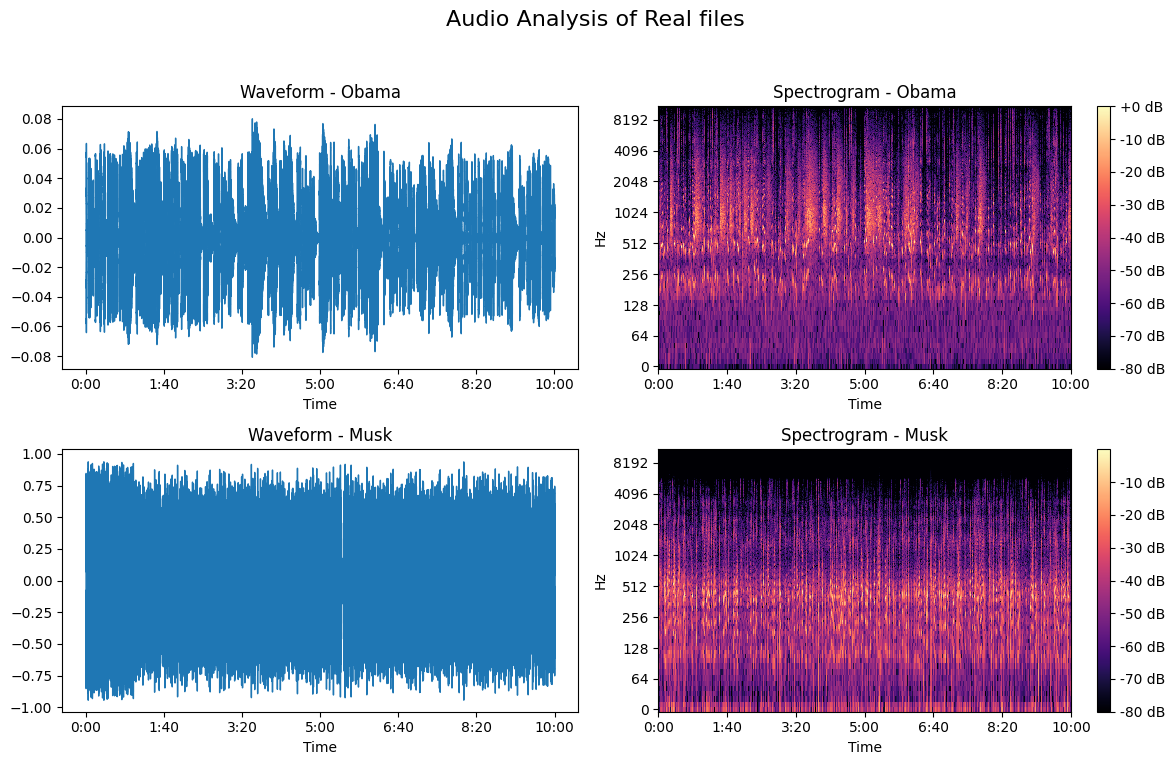

In [ ]:
def plot_audio_analysis(audio_paths, names, title, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
    fig.suptitle(title, fontsize=16)

    for i, (audio_path, name) in enumerate(zip(audio_paths, names)):
        y, sr = librosa.load(audio_path)

        # Waveform
        librosa.display.waveshow(y, sr=sr, ax=axes[i, 0])
        axes[i, 0].set_title(f"Waveform - {name}")

        # Spectrogram
        D = librosa.stft(y)
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', ax=axes[i, 1])
        axes[i,1].set_title(f"Spectrogram - {name}")
        fig.colorbar(img, ax=axes[i,1], format="%+2.f dB")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


audio_files = [obama_original_path, musk_original_path]
person_names = ["Obama", "Musk"]

plot_audio_analysis(audio_files, person_names, "Audio Analysis of Real files", nrows=2, ncols=2)

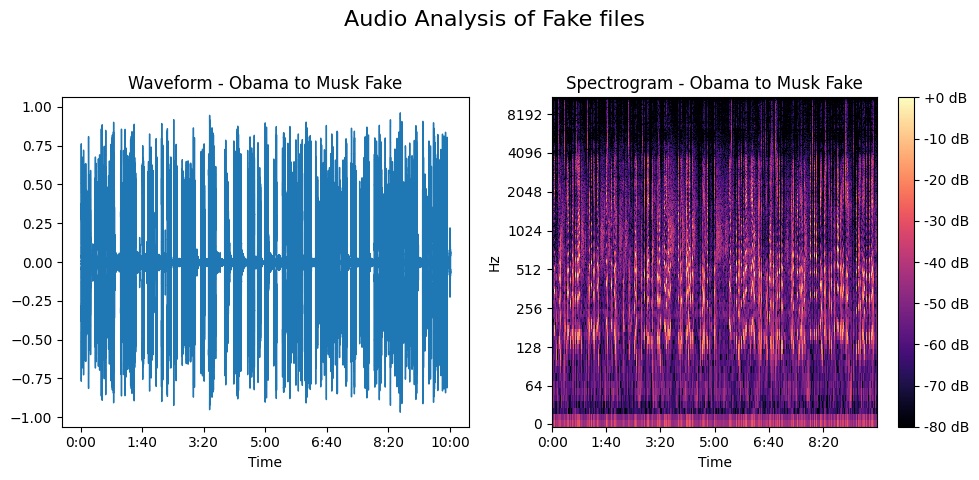

In [ ]:
audio_files = [obama_to_musk_fake_path]
person_names = ["Obama to Musk Fake"]

plot_audio_analysis(audio_files, person_names, "Audio Analysis of Fake files", nrows=1, ncols=2)

### Data Preprocessing

#### Feature Extraction

In [ ]:
def extract_features_from_window(y, sr):
    features = {}
    features['chroma_stft'] = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    features['rms'] = np.mean(librosa.feature.rms(y=y))
    features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    features['spectral_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    features['rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))

    # Check if the audio segment is silent before calculating zero-crossing rate
    if len(y) > 0 and np.mean(np.abs(y)) > 1e-6:
        features['zero_crossing_rate'] = np.mean(librosa.feature.zero_crossing_rate(y))
    else:
        features['zero_crossing_rate'] = 0  # Assign 0 for silent segments

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    for i in range(1, 21):
        features[f'mfcc{i}'] = np.mean(mfcc[i - 1])

    return features

In [ ]:
def process_audio_file(file_path, label, sr=22050, duration=1.0):
    y, _ = librosa.load(file_path, sr=sr)
    total_secs = int(len(y) / sr)
    feature_list = []

    for start in range(0, total_secs):
        end = start + int(sr * duration)
        if end > len(y): break
        window = y[start * sr : end]
        features = extract_features_from_window(window, sr)
        features['LABEL'] = label
        feature_list.append(features)

    return feature_list

In [ ]:
def process_folder(folder_path, label):
    audio_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".wav")]
    results = Parallel(n_jobs=-1)(delayed(process_audio_file)(fp, label) for fp in tqdm(audio_files))
    return [item for sublist in results for item in sublist]  # flatten

In [ ]:
real_data = process_folder("/content/deep-voice-dataset/KAGGLE/AUDIO/REAL", "REAL")
fake_data = process_folder("/content/deep-voice-dataset/KAGGLE/AUDIO/FAKE", "FAKE")

# Balance
min_len = min(len(real_data), len(fake_data))
real_sampled = random.sample(real_data, min_len)
fake_sampled = random.sample(fake_data, min_len)

# Combine
balanced_data = real_sampled + fake_sampled
random.shuffle(balanced_data)

# Save as CSV
df = pd.DataFrame(balanced_data)


100%|██████████| 8/8 [00:40<00:00,  5.03s/it]

100%|██████████| 56/56 [04:20<00:00,  4.66s/it]


In [ ]:
df.head()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
0,0.345164,0.093046,1046.960347,1351.222347,1937.739342,0.030344,-306.160889,209.618683,3.123975,-8.502362,...,-3.370094,3.654903,7.627326,2.072889,-1.353799,-4.490911,-2.061353,8.683665,5.916374,REAL
1,0.413513,0.036381,2491.025441,3311.032008,4544.187898,0.057586,-393.681976,119.923439,-8.315945,11.332471,...,-5.724184,0.312014,-11.306483,-4.047928,0.661722,-5.848134,2.367994,-2.729973,-5.376225,FAKE
2,0.410590,0.005929,3457.983055,4609.747187,8337.391955,0.068554,-548.589783,143.375290,-14.965715,27.975279,...,-5.948756,-0.539809,0.640393,-3.083493,3.438543,1.779330,-7.211283,-4.343725,-1.700251,REAL
3,0.386347,0.057184,2546.720650,3192.849895,4914.535231,0.057082,-375.128845,128.916504,5.639764,18.972616,...,-12.798991,-2.167072,-0.652868,-4.042820,-7.214348,-4.725709,-6.279426,-7.225828,-5.566360,FAKE
4,0.482205,0.006853,5263.562287,4361.693848,10086.874270,0.164805,-452.446808,75.893646,-20.061228,49.314407,...,-7.387821,-8.310212,-4.881917,0.014762,-10.778668,-2.678419,-10.095864,-1.754935,-13.179572,REAL


* Saving the balanced data into .csv format for our next part of the study.
* Going forward, we will work with this balanced data which is a representative of our raw data of audio files.

In [ ]:
df.to_csv("data-balanced.csv", index=False)

---
                                                         
                                                          
                                                           
                                                            
                                                             Thank You :)